In [1]:
using Plots, NLSolvers # define packages

In [2]:
# define constants
const V0 = 3. # the value has to be taken from the figure 1
const N = 400 # number of x points
const L_real_turing = 0.05 # total length also non-dimensional point (l/re)
const L_real_waves = 0.015
const c = 1.82;
const Vr = 3;
const dt = 0.05;   # adimensional time step 

In [23]:
# define functions

function sigmoid(V_mat) 
    return 1 ./ (1 .+ exp.(-c .* (V_mat.-Vr)))
end

const G0 = 2 .* sigmoid(V0*ones(1,N+1))

function G(V,nt,n,du,v) 
    nx = 0:N
    timedelayed = nt*dt .- (n.*du./v)
    ntdelayed = Int64(round(timedelayed / dt))
    if ntdelayed < 1
        return G0
    else
        G1 = sigmoid(V[ntdelayed,mod1.((nx.-n.+1),N+1)])
        G2 = sigmoid(V[ntdelayed,((nx.+n).%(N+1).+1)])
        return permutedims(G1.+G2)
    end      
end

function integral_function(V,nt,eta,du,v,c1,c2,c3,GG)
    b = (1/eta).*(GG[1,:] .+(GG[2,:] .-GG[1,:])./(eta.*du)); 
    #display(b)
    K = c2.*(GG[N+1,:].+(GG[N+1,:].-GG[N,:])./(eta.*du)); 
    #display(K)
    cc = zeros(N+1,N-1)
    cc2 = cc
    for nn = 1:N-1
        cc[:,nn] = c3[nn].*(GG[nn+2,:] .-2 .*GG[nn+1,:] .+ GG[nn,:]); # c3 = exp.(-eta.*((nn+1).*du))
    end 
    summ = sum(cc,dims=2)
    #display(c1.*summ .+ b .- K)

    #a = 1 ./((eta.^2).*du);
    # display(a)
    #bb = (1 ./eta).*(G(V,nt,0,du,v).+(G(V,nt,1,du,v).-G(V,nt,0,du,v))./(eta.*du));
    # display(b)
    #KK = (1 ./eta).*exp.(-eta.*L).*(G(V,nt,N+1,du,v).+(G(V,nt,N+1,du,v).-G(V,nt,N,du,v))./(eta.*du))
    # display(K)
    #cc2 = zeros(N-1,N+1)
    #for nn = 0:N-2
    #    cc2[nn+1,:] = exp.(-eta.*((nn+1).*du)).*(G(V,nt,nn+2,du,v).-2 .*G(V,nt,nn+1,du,v).+G(V,nt,nn,du,v));
    #end 
    #summ2 = sum(cc2,dims=1)
    #display(a.*summ2 .+ bb .- KK)
    return c1.*summ .+ b .- K
end

function J_function(V,nt,eta,du,v,ae,ai,c1,c2,c3,GG)
    J_e = ae.*eta[1].*integral_function(V,nt,eta[1],du,v,c1[1],c2[1],c3[:,1],GG);
    J_i = ai.*eta[2].*integral_function(V,nt,eta[2],du,v,c1[2],c2[2],c3[:,2],GG);
    #println("J function")
    #display(0.5 .* (J_e .- J_i) )
    return 0.5 .* (J_e .- J_i) 
end

function brainPatterns(V,eta,du,v,ae,ai,muP,N_t) 
    # define matrixes used 
    J=zeros(size(V)); phi = zeros(size(V));
    # compute constant parameters which not depends on the nt
    c1 = 1 ./ ((eta.^2).*du);
    c2 = (1 ./eta).*exp.(-eta.*L)
    nn = 0:N-2; c3 = exp.(-eta.*((nn.+1).*du))
    
    for nt = 1:N_t-1
        # iteration check
        if nt%100 == 0
            display(nt)
        end
        # precompute G function for the current nt. horizontal dimension: space. vertical dimension: delay (n)
        GG = zeros(N+1,N+1)
        for nn = 0:N
            GG[nn+1,:] = G(V,nt,nn,du,v)
        end
        
        J[nt,:] = J_function(V,nt,eta,du,v,ae,ai,c1,c2,c3,GG);
        V[nt+1,:] = V[nt,:] .+ dt.*phi[nt,:]
        phi[nt+1,:] = phi[nt,:] .+ dt.*(-2 .*phi[nt,:] .- V[nt,:] .+ J[nt,:] .+ muP)
    end
    return V,J,phi
end

brainPatterns (generic function with 1 method)

In [20]:
# Turing Patterns (FIG. 7)
# parameters
ae = 6.;     # excitatory strenght
ai = 5.;     # inhibitory strenght
re = 0.0005;    # excitatory range (m)
ri = 0.001;     # inhibitory range (m)
r = re/ri;   # ratio
v_real = 0.08;# propagation velocity (m/s)
v = v_real / (re * sqrt(400*400))
L = L_real_turing / re
du = L/N;
x = 0:du:L;
muP0 = 2.5;   # external stimulus (constant)
T = 200
t = 0:dt:T/dt   # not sure

eta_e = 1.0
eta_i = r
eta = [1.0 r]
N_t = length(t);

V = zeros(N_t,(N+1)); # this are the true dimensions of the V matrix
V[1,:] = V0.*ones(1,N+1) .+ 0.05 .*randn(1,N+1);

@time begin
V,J = brainPatterns(V,eta,du,v,ae,ai,muP0,10000);
end

1000

2000

3000

4000

5000

6000

7000

8000

9000

251.170625 seconds (59.52 M allocations: 204.934 GiB, 10.91% gc time)


([2.904072947992729 3.0365017951402784 … 3.0806805523080474 2.9661331528463735; 2.904072947992729 3.0365017951402784 … 3.0806805523080474 2.9661331528463735; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.48296239501842253 0.5064971540161545 … 0.514340296339852 0.4939715463877201; 0.48296239501842253 0.5064971540161545 … 0.514340296339852 0.4939715463877201; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0039444723512846785 -0.0015002320562061966 … -0.0033170127984097687 0.0013919196770673327; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [21]:
display(V[1:10000,:])


10000×401 Matrix{Float64}:
 2.90407  3.0365   2.93644  3.03955  …  3.01294  3.01182  3.08068  2.96613
 2.90407  3.0365   2.93644  3.03955     3.01294  3.01182  3.08068  2.96613
 2.90427  3.03643  2.93657  3.03947     3.01292  3.0118   3.08051  2.9662
 2.90464  3.03628  2.93682  3.03932     3.01286  3.01175  3.0802   2.96633
 2.90518  3.03608  2.93717  3.03909     3.01279  3.01169  3.07975  2.96652
 2.90586  3.03582  2.93762  3.03882  …  3.0127   3.0116   3.07918  2.96676
 2.90666  3.03552  2.93815  3.03848     3.01259  3.01151  3.07851  2.96705
 2.90758  3.03517  2.93876  3.03811     3.01247  3.01139  3.07773  2.96737
 2.90859  3.03478  2.93944  3.03769     3.01233  3.01127  3.07688  2.96773
 2.9097   3.03436  2.94017  3.03723     3.01218  3.01113  3.07595  2.96812
 2.91088  3.03391  2.94095  3.03674  …  3.01202  3.01099  3.07495  2.96854
 2.91213  3.03344  2.94178  3.03623     3.01186  3.01083  3.0739   2.96898
 2.91344  3.03294  2.94265  3.03569     3.01168  3.01067  3.0728   2.96944

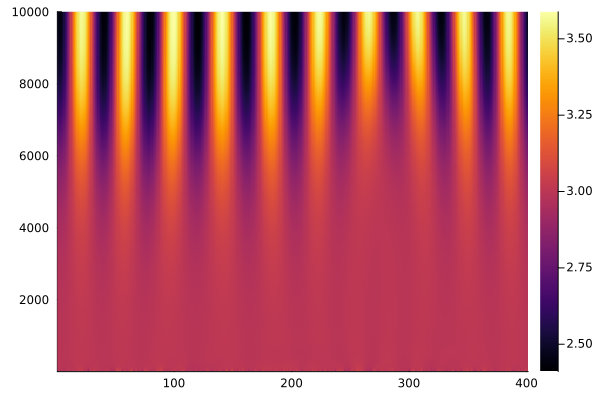

In [22]:
heatmap(V[1:10000,:])

In [ ]:
# Waves - homogeneous stimulus - close to the threshold (FIG. 8)


v = 0.16;    # propagation velocity (m/s)
ae = 41;     # excitatory strenght
ai = 40;     # inhibitory strenght
re = 0.001;    # excitatory range (m)
ri = 0.00037;     # inhibitory range (m)
r = re/ri;   # ratio
v_real = 0.16;# propagation velocity (m/s)
v = v_real / (re * sqrt(400*400))
L = L_real_waves / re
du = L/N;
x = 0:du:L;
muP0 = 2.5;   # external stimulus (constant)
T = 200
t = 0:dt:T/dt   # not sure

eta = [1.0 r]
N_t = length(t);
V = zeros(N_t,(N+1)); # this are the true dimensions of the V matrix

V[1,:] = V0.*ones(1,N+1) .+ 0.05 .*randn(1,N+1);

@time begin
V,J = brainPatterns(V,eta,du,v,ae,ai,muP0,20000);
end

100

200

300

400

500

600

700

800

900

1000

1100

1200

1300

1400

1500

1600

1700

1800

1900

2000

2100

2200

2300

2400

2500

2600

2700

2800

2900

3000

3100

3200

3300

3400

3500

3600

3700

3800

3900

4000

4100

4200

4300

4400

4500

4600

4700

4800

4900

5000

5100

5200

5300

5400

5500

5600

5700

5800

5900

6000

6100

6200

6300

6400

6500

6600

6700

6800

6900

7000

7100

7200

7300

7400

7500

7600

7700

7800

7900

8000

8100

8200

8300

8400

8500

8600

8700

8800

8900

9000

9100

9200

9300

9400

9500

9600

9700

9800

9900

10000

10100

10200

10300

10400

10500

10600

10700

10800

10900

11000

11100

11200

11300

11400

11500

11600

11700

11800

11900

12000

12100

12200

12300

12400

12500

12600

12700

12800

12900

13000

13100

13200

13300

13400

13500

13600

13700

13800

13900

14000

14100

In [20]:
display(V[1:20000,:])


2000×401 Matrix{Float64}:
 3.05057  3.10606  3.00605  3.02239  …  3.01657  3.03189  2.96289  2.95426
 3.05057  3.10606  3.00605  3.02239     3.01657  3.03189  2.96289  2.95426
 3.05024  3.10537  3.00601  3.02224     3.01646  3.03168  2.96314  2.95456
 3.0496   3.10404  3.00593  3.02196     3.01625  3.03128  2.9636   2.95513
 3.0487   3.10215  3.00582  3.02157     3.01596  3.03071  2.96426  2.95595
 3.04756  3.09977  3.00569  3.02106  …  3.01558  3.02999  2.9651   2.95698
 3.04622  3.09696  3.00553  3.02047     3.01514  3.02914  2.96608  2.95819
 3.0447   3.09376  3.00534  3.01979     3.01464  3.02818  2.9672   2.95957
 3.04284  3.09009  3.00476  3.01895     3.01395  3.02719  2.96847  2.96105
 3.0407   3.08599  3.00383  3.01796     3.01308  3.02617  2.96987  2.9626
 3.03832  3.08155  3.00258  3.01685  …  3.01207  3.02513  2.97138  2.96422
 3.03573  3.07682  3.00106  3.01563     3.01093  3.02408  2.97298  2.96588
 3.03298  3.07186  2.9993   3.01432     3.00969  3.02303  2.97464  2.96758


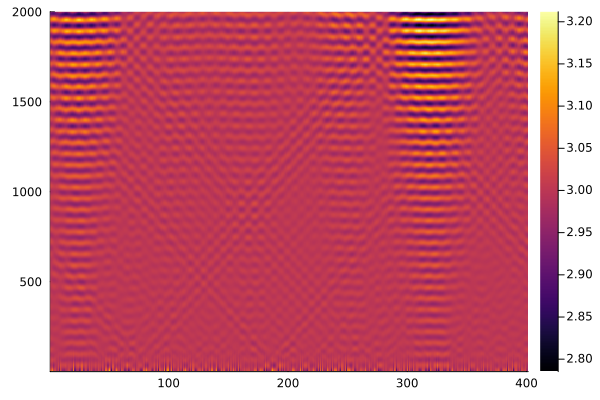

In [21]:
heatmap(V[1:20000,:])

In [24]:
## Waves ## - Homogeneous external stimulation - Well above threshold
re = 0.001;       # excitatory range (m)
ri = 0.0001;

ai = 100.;
ae = 101.;



r = re/ri;   # ratio
v_real = 0.16; # propagation velocity (m/s)
v = v_real / (re * sqrt(400*400))
L = L_real / re
du = L/N;
x = 0:du:L;
muP0 = 2.5;   # external stimulus (constant)
T = 200
t = 0:dt:T/dt   # not sure
muP = muP0*ones(1,N+1)
x1 = Int64(round((0.475*L)/(du)))+1;
display(x1)
x2 = Int64(round((0.525*L)/(du)))+1;
display(x2)
for i = x1:x2
    muP[i] = muP[i] + 20;
end

eta_1 = 1.0
eta_2 = r
N_t = length(t);
V = zeros(N_t,(N+1)); # this are the true dimensions of the V matrix

V[1,:] = V0.*ones(1,N+1) .+ 0.05 .*randn(1,N+1);

V,J = brainPatterns(V,eta_1,eta_2,du,v,ae,ai,phi,muP',2000);

1

1

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

90

91

92

93

94

95

96

97

98

99

100

101

102

103

104

105

106

107

108

109

110

111

112

113

114

115

116

117

118

119

120

121

122

123

124

125

126

127

128

129

130

131

132

133

134

135

136

137

138

139

140

141

142

143

144

145

146

147

148

149

150

151

152

153

154

155

156

157

158

159

160

161

162

163

164

165

166

167

168

169

170

171

172

173

174

175

176

177

178

179

180

181

182

183

184

185

186

187

188

189

190

191

192

193

194

195

196

197

198

199

200

201

202

203

204

205

206

207

208

209

210

211

212

213

214

215

216

217

218

219

220

221

222

223

224

225

226

227

228

229

230

231

232

233

234

235

236

237

238

239

240

241

242

243

244

245

246

247

248

249

250

251

252

253

254

255

256

257

258

259

260

261

262

263

264

265

266

267

268

269

270

271

272

273

274

275

276

277

278

279

280

281

282

283

284

285

286

287

288

289

290

291

292

293

294

295

296

297

298

299

300

301

302

303

304

305

306

307

308

309

310

311

312

313

314

315

316

317

318

319

320

321

322

323

324

325

326

327

328

329

330

331

332

333

334

335

336

337

338

339

340

341

342

343

344

345

346

347

348

349

350

351

352

353

354

355

356

357

358

359

360

361

362

363

364

365

366

367

368

369

370

371

372

373

374

375

376

377

378

379

380

381

382

383

384

385

386

387

388

389

390

391

392

393

394

395

396

397

398

399

400

401

402

403

404

405

406

407

408

409

410

411

412

413

414

415

416

417

418

419

420

421

422

423

424

425

426

427

428

429

430

431

432

433

434

435

436

437

438

439

440

441

442

443

444

445

446

447

448

449

450

451

452

453

454

455

456

457

458

459

460

461

462

463

464

465

466

467

468

469

470

471

472

473

474

475

476

477

478

479

480

481

482

483

484

485

486

487

488

489

490

491

492

493

494

495

496

497

498

499

500

501

502

503

504

505

506

507

508

509

510

511

512

513

514

515

516

517

518

519

520

521

522

523

524

525

526

527

528

529

530

531

532

533

534

535

536

537

538

539

540

541

542

543

544

545

546

547

548

549

550

551

552

553

554

555

556

557

558

559

560

561

562

563

564

565

566

567

568

569

570

571

572

573

574

575

576

577

578

579

580

581

582

583

584

585

586

587

588

589

590

591

592

593

594

595

596

597

598

599

600

601

602

603

604

605

606

607

608

609

610

611

612

613

614

615

616

617

618

619

620

621

622

623

624

625

626

627

628

629

630

631

632

633

634

635

636

637

638

639

640

641

642

643

644

645

646

647

648

649

650

651

652

653

654

655

656

657

658

659

660

661

662

663

664

665

666

667

668

669

670

671

672

673

674

675

676

677

678

679

680

681

682

683

684

685

686

687

688

689

690

691

692

693

694

695

696

697

698

699

700

701

702

703

704

705

706

707

708

709

710

711

712

713

714

715

716

717

718

719

720

721

722

723

724

725

726

727

728

729

730

731

732

733

734

735

736

737

738

739

740

741

742

743

744

745

746

747

748

749

750

751

752

753

754

755

756

757

758

759

760

761

762

763

764

765

766

767

768

769

770

771

772

773

774

775

776

777

778

779

780

781

782

783

784

785

786

787

788

789

790

791

792

793

794

795

796

797

798

799

800

801

802

803

804

805

806

807

808

809

810

811

812

813

814

815

816

817

818

819

820

821

822

823

824

825

826

827

828

829

830

831

832

833

834

835

836

837

838

839

840

841

842

843

844

845

846

847

848

849

850

851

852

853

854

855

856

857

858

859

860

861

862

863

864

865

866

867

868

869

870

871

872

873

874

875

876

877

878

879

880

881

882

883

884

885

886

887

888

889

890

891

892

893

894

895

896

897

898

899

900

901

902

903

904

905

906

907

908

909

910

911

912

913

914

915

916

917

918

919

920

921

922

923

924

925

926

927

928

929

930

931

932

933

934

935

936

937

938

939

940

941

942

943

944

945

946

947

948

949

950

951

952

953

954

955

956

957

958

959

960

961

962

963

964

965

966

967

968

969

970

971

972

973

974

975

976

977

978

979

980

981

982

983

984

985

986

987

988

989

990

991

992

993

994

995

996

997

998

999

1000

1001

1002

1003

1004

1005

1006

1007

1008

1009

1010

1011

1012

1013

1014

1015

1016

1017

1018

1019

1020

1021

1022

1023

1024

1025

1026

1027

1028

1029

1030

1031

1032

1033

1034

1035

1036

1037

1038

1039

1040

1041

1042

1043

1044

1045

1046

1047

1048

1049

1050

1051

1052

1053

1054

1055

1056

1057

1058

1059

1060

1061

1062

1063

1064

1065

1066

1067

1068

1069

1070

1071

1072

1073

1074

1075

1076

1077

1078

1079

1080

1081

1082

1083

1084

1085

1086

1087

1088

1089

1090

1091

1092

1093

1094

1095

1096

1097

1098

1099

1100

1101

1102

1103

1104

1105

1106

1107

1108

1109

1110

1111

1112

1113

1114

1115

1116

1117

1118

1119

1120

1121

1122

1123

1124

1125

1126

1127

1128

1129

1130

1131

1132

1133

1134

1135

1136

1137

1138

1139

1140

1141

1142

1143

1144

1145

1146

1147

1148

1149

1150

1151

1152

1153

1154

1155

1156

1157

1158

1159

1160

1161

1162

1163

1164

1165

1166

1167

1168

1169

1170

1171

1172

1173

1174

1175

1176

1177

1178

1179

1180

1181

1182

1183

1184

1185

1186

1187

1188

1189

1190

1191

1192

1193

1194

1195

1196

1197

1198

1199

1200

1201

1202

1203

1204

1205

1206

1207

1208

1209

1210

1211

1212

1213

1214

1215

1216

1217

1218

1219

1220

1221

1222

1223

1224

1225

1226

1227

1228

1229

1230

1231

1232

1233

1234

1235

1236

1237

1238

1239

1240

1241

1242

1243

1244

1245

1246

1247

1248

1249

1250

1251

1252

1253

1254

1255

1256

1257

1258

1259

1260

1261

1262

1263

1264

1265

1266

1267

1268

1269

1270

1271

1272

1273

1274

1275

1276

1277

1278

1279

1280

1281

1282

1283

1284

1285

1286

1287

1288

1289

1290

1291

1292

1293

1294

1295

1296

1297

1298

1299

1300

1301

1302

1303

1304

1305

1306

1307

1308

1309

1310

1311

1312

1313

1314

1315

1316

1317

1318

1319

1320

1321

1322

1323

1324

1325

1326

1327

1328

1329

1330

1331

1332

1333

1334

1335

1336

1337

1338

1339

1340

1341

1342

1343

1344

1345

1346

1347

1348

1349

1350

1351

1352

1353

1354

1355

1356

1357

1358

1359

1360

1361

1362

1363

1364

1365

1366

1367

1368

1369

1370

1371

1372

1373

1374

1375

1376

1377

1378

1379

1380

1381

1382

1383

1384

1385

1386

1387

1388

1389

1390

1391

1392

1393

1394

1395

1396

1397

1398

1399

1400

1401

1402

1403

1404

1405

1406

1407

1408

1409

1410

1411

1412

1413

1414

1415

1416

1417

1418

1419

1420

1421

1422

1423

1424

1425

1426

1427

1428

1429

1430

1431

1432

1433

1434

1435

1436

1437

1438

1439

1440

1441

1442

1443

1444

1445

1446

1447

1448

1449

1450

1451

1452

1453

1454

1455

1456

1457

1458

1459

1460

1461

1462

1463

1464

1465

1466

1467

1468

1469

1470

1471

1472

1473

1474

1475

1476

1477

1478

1479

1480

1481

1482

1483

1484

1485

1486

1487

1488

1489

1490

1491

1492

1493

1494

1495

1496

1497

1498

1499

1500

1501

1502

1503

1504

1505

1506

1507

1508

1509

1510

1511

1512

1513

1514

1515

1516

1517

1518

1519

1520

1521

1522

1523

1524

1525

1526

1527

1528

1529

1530

1531

1532

1533

1534

1535

1536

1537

1538

1539

1540

1541

1542

1543

1544

1545

1546

1547

1548

1549

1550

1551

1552

1553

1554

1555

1556

1557

1558

1559

1560

1561

1562

1563

1564

1565

1566

1567

1568

1569

1570

1571

1572

1573

1574

1575

1576

1577

1578

1579

1580

1581

1582

1583

1584

1585

1586

1587

1588

1589

1590

1591

1592

1593

1594

1595

1596

1597

1598

1599

1600

1601

1602

1603

1604

1605

1606

1607

1608

1609

1610

1611

1612

1613

1614

1615

1616

1617

1618

1619

1620

1621

1622

1623

1624

1625

1626

1627

1628

1629

1630

1631

1632

1633

1634

1635

1636

1637

1638

1639

1640

1641

1642

1643

1644

1645

1646

1647

1648

1649

1650

1651

1652

1653

1654

1655

1656

1657

1658

1659

1660

1661

1662

1663

1664

1665

1666

1667

1668

1669

1670

1671

1672

1673

1674

1675

1676

1677

1678

1679

1680

1681

1682

1683

1684

1685

1686

1687

1688

1689

1690

1691

1692

1693

1694

1695

1696

1697

1698

1699

1700

1701

1702

1703

1704

1705

1706

1707

1708

1709

1710

1711

1712

1713

1714

1715

1716

1717

1718

1719

1720

1721

1722

1723

1724

1725

1726

1727

1728

1729

1730

1731

1732

1733

1734

1735

1736

1737

1738

1739

1740

1741

1742

1743

1744

1745

1746

1747

1748

1749

1750

1751

1752

1753

1754

1755

1756

1757

1758

1759

1760

1761

1762

1763

1764

1765

1766

1767

1768

1769

1770

1771

1772

1773

1774

1775

1776

1777

1778

1779

1780

1781

1782

1783

1784

1785

1786

1787

1788

1789

1790

1791

1792

1793

1794

1795

1796

1797

1798

1799

1800

1801

1802

1803

1804

1805

1806

1807

1808

1809

1810

1811

1812

1813

1814

1815

1816

1817

1818

1819

1820

1821

1822

1823

1824

1825

1826

1827

1828

1829

1830

1831

1832

1833

1834

1835

1836

1837

1838

1839

1840

1841

1842

1843

1844

1845

1846

1847

1848

1849

1850

1851

1852

1853

1854

1855

1856

1857

1858

1859

1860

1861

1862

1863

1864

1865

1866

1867

1868

1869

1870

1871

1872

1873

1874

1875

1876

1877

1878

1879

1880

1881

1882

1883

1884

1885

1886

1887

1888

1889

1890

1891

1892

1893

1894

1895

1896

1897

1898

1899

1900

1901

1902

1903

1904

1905

1906

1907

1908

1909

1910

1911

1912

1913

1914

1915

1916

1917

1918

1919

1920

1921

1922

1923

1924

1925

1926

1927

1928

1929

1930

1931

1932

1933

1934

1935

1936

1937

1938

1939

1940

1941

1942

1943

1944

1945

1946

1947

1948

1949

1950

1951

1952

1953

1954

1955

1956

1957

1958

1959

1960

1961

1962

1963

1964

1965

1966

1967

1968

1969

1970

1971

1972

1973

1974

1975

1976

1977

1978

1979

1980

1981

1982

1983

1984

1985

1986

1987

1988

1989

1990

1991

1992

1993

1994

1995

1996

1997

1998

1999

In [26]:
display(V[1:2000,:])


2000×401 Matrix{Float64}:
  3.00181   2.97065   3.02702    2.94649  …    2.95612    3.02121   2.9537
  3.00181   2.97065   3.02702    2.94649       2.95612    3.02121   2.9537
  3.05189   2.96947   3.0281     2.94435       2.95437    3.02206   2.95185
  3.14702   2.96724   3.03015    2.94029       2.95103    3.02367   2.94833
  3.28472   2.96402   3.03312    2.93441       2.94621    3.026     2.94324
  3.46449   2.9598    3.037      2.92673  …    2.93992    3.02905   2.9366
  3.6874    2.95457   3.04182    2.91721       2.9321     3.03283   2.92835
  3.9555    2.94826   3.04763    2.9057        2.92266    3.03739   2.9184
  4.26969   2.94125   3.05312    2.89234       2.91227    3.04127   2.90697
  4.63152   2.93337   3.05854    2.87685       2.90062    3.04471   2.89383
  5.0409    2.92531   3.06407    2.85892  …    2.88748    3.04785   2.87955
  5.49596   2.9184    3.06981    2.83821       2.87259    3.05075   2.86538
  5.99329   2.91453   3.07579    2.81432       2.85568    3.05337 

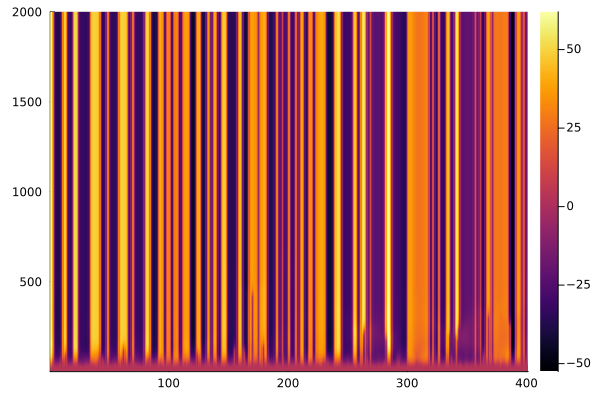

In [27]:
heatmap(V[1:2000,:])

In [15]:
## Homogeneous external stimuli
muP0 = 2.5;       # external stimulus (constant)
r = 2.8;          # ratio
ri = re/r;        # inhibitory range (m)
ai = 40.;         # excitatory strenght
ae = 41.;         # inhibitory strenght

In [16]:
## Inhimogeneous external stimulation
muP0 = 2.5;
function muP(x,t)
    return
end
ri = 0.0001;
re = 0.001;
r = re/ri;
ai = 100.;
ae = 101.;

LoadError: cannot define function muP; it already has a value

In [14]:
eta = [1 r]
c1 = eta.*du
nn = 0:N-2; c3 = exp.(-eta.*((nn.+1).*du))

399×2 Matrix{Float64}:
 0.778801     0.882497
 0.606531     0.778801
 0.472367     0.687289
 0.367879     0.606531
 0.286505     0.535261
 0.22313      0.472367
 0.173774     0.416862
 0.135335     0.367879
 0.105399     0.324652
 0.082085     0.286505
 0.0639279    0.25284
 0.0497871    0.22313
 0.0387742    0.196912
 ⋮            
 7.47197e-43  8.64406e-22
 5.81918e-43  7.62835e-22
 4.53198e-43  6.732e-22
 3.52951e-43  5.94097e-22
 2.74879e-43  5.24289e-22
 2.14076e-43  4.62683e-22
 1.66722e-43  4.08316e-22
 1.29843e-43  3.60338e-22
 1.01122e-43  3.17997e-22
 7.8754e-44   2.80631e-22
 6.13337e-44  2.47656e-22
 4.77667e-44  2.18556e-22